In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [3]:
df = pd.read_csv("../input/customer-personality-analysis/marketing_campaign.csv", sep="\t")

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


#EDA

In [5]:
df.shape

(2240, 29)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [1]:
df.describe().T.style.background_gradient(cmap = "Blues")

NameError: name 'df' is not defined

In [8]:
df.corr().style.background_gradient(cmap = "Blues")

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,1.000000,0.000028,0.013095,0.002406,-0.002580,-0.046524,-0.022878,0.004600,-0.004437,-0.024475,-0.007642,-0.013438,-0.037166,-0.018924,-0.003440,-0.014927,-0.007446,-0.036040,-0.025387,-0.007517,-0.021614,-0.015061,0.033883,nan,nan,-0.021968
Year_Birth,0.000028,1.000000,-0.161791,0.230176,-0.352111,-0.019871,-0.157773,-0.017917,-0.030872,-0.041625,-0.018133,-0.061818,-0.060846,-0.145040,-0.121275,-0.128272,0.121139,0.061774,-0.060510,0.007123,-0.005930,-0.006539,-0.030128,nan,nan,0.021325
Income,0.013095,-0.161791,1.000000,-0.428669,0.019133,-0.003970,0.578650,0.430842,0.584633,0.438871,0.440744,0.325916,-0.083101,0.387878,0.589162,0.529362,-0.553088,-0.016174,0.184400,0.335943,0.276820,0.087545,-0.027225,nan,nan,0.133047
Kidhome,0.002406,0.230176,-0.428669,1.000000,-0.036133,0.008827,-0.496297,-0.372581,-0.437129,-0.387644,-0.370673,-0.349595,0.221798,-0.361647,-0.502237,-0.499683,0.447846,0.014674,-0.161600,-0.205634,-0.172339,-0.081716,0.040207,nan,nan,-0.080008
Teenhome,-0.002580,-0.352111,0.019133,-0.036133,1.000000,0.016198,0.004846,-0.176764,-0.261160,-0.204187,-0.162475,-0.021725,0.387741,0.155500,-0.110769,0.050695,0.134884,-0.042677,0.038886,-0.191050,-0.140090,-0.015605,0.003138,nan,nan,-0.154446
Recency,-0.046524,-0.019871,-0.003970,0.008827,0.016198,1.000000,0.016064,-0.004306,0.023056,0.001079,0.022670,0.016693,-0.001098,-0.010726,0.025110,0.000799,-0.021445,-0.032991,0.018826,0.000129,-0.019283,-0.001781,0.013231,nan,nan,-0.198437
MntWines,-0.022878,-0.157773,0.578650,-0.496297,0.004846,0.016064,1.000000,0.389637,0.562667,0.399753,0.386581,0.387516,0.010940,0.542265,0.635226,0.642100,-0.320653,0.062202,0.373286,0.472613,0.354133,0.205907,-0.039007,nan,nan,0.247254
MntFruits,0.004600,-0.017917,0.430842,-0.372581,-0.176764,-0.004306,0.389637,1.000000,0.543105,0.594804,0.567164,0.392995,-0.132114,0.296735,0.487917,0.461758,-0.418383,0.014727,0.010152,0.215833,0.194748,-0.009773,-0.005166,nan,nan,0.125289
MntMeatProducts,-0.004437,-0.030872,0.584633,-0.437129,-0.261160,0.023056,0.562667,0.543105,1.000000,0.568402,0.523846,0.350609,-0.122415,0.293761,0.723827,0.479659,-0.539470,0.018272,0.102912,0.373769,0.309761,0.043033,-0.023483,nan,nan,0.236335
MntFishProducts,-0.024475,-0.041625,0.438871,-0.387644,-0.204187,0.001079,0.399753,0.594804,0.568402,1.000000,0.579870,0.422875,-0.139361,0.293681,0.534478,0.459855,-0.446003,0.000357,0.016843,0.199578,0.260762,0.002577,-0.020953,nan,nan,0.111331


* feature Income have missing value

In [9]:
df.describe(include=object)

,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,31-08-2012
freq,1127,864,12


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


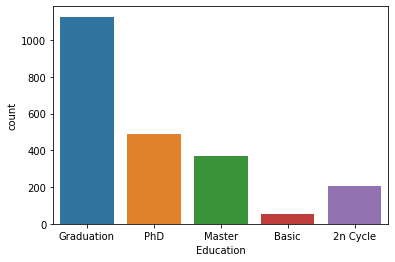

In [10]:
sns.countplot(df['Education'],label="Count")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


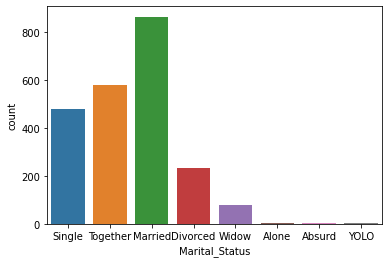

In [11]:
sns.countplot(df['Marital_Status'],label="Count")
plt.show()

#Preprocessing

In [12]:
#drop feature that have unique value
df = df.drop('ID', axis=1)

#Drop feature where have std = 0
df = df.drop('Z_CostContact', axis=1)
df = df.drop('Z_Revenue', axis=1)

In [13]:
df.Dt_Customer.dtype

dtype('O')

In [14]:
df['date_parsed'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")

In [15]:
df['date_parsed'].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: date_parsed, dtype: datetime64[ns]

In [16]:
df['day_enrollment'] = df['date_parsed'].dt.day
df['month_enrollment'] = df['date_parsed'].dt.month
df['year_enrollment'] = df['date_parsed'].dt.year

In [17]:
missing_values_count = df.isnull().sum()
missing_values_count

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
date_parsed             0
day_enrollment          0
month_enrollment        0
year_enrollment         0
dtype: int64

In [18]:
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.03571428571428571


In [19]:
df = df.dropna(axis=1)
df.shape

(2240, 29)

In [20]:
missing_values_count2 = df.isnull().sum()
missing_values_count2

Year_Birth             0
Education              0
Marital_Status         0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
date_parsed            0
day_enrollment         0
month_enrollment       0
year_enrollment        0
dtype: int64

In [2]:
df.describe().T.style.background_gradient(cmap = "Blues")

NameError: name 'df' is not defined

In [22]:
df.corr().style.background_gradient(cmap = "Blues")

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,day_enrollment,month_enrollment,year_enrollment
Year_Birth,1.000000,0.230176,-0.352111,-0.019871,-0.157773,-0.017917,-0.030872,-0.041625,-0.018133,-0.061818,-0.060846,-0.145040,-0.121275,-0.128272,0.121139,0.061774,-0.060510,0.007123,-0.005930,-0.006539,-0.030128,0.021325,-0.009193,0.024246,-0.028188
Kidhome,0.230176,1.000000,-0.036133,0.008827,-0.496297,-0.372581,-0.437129,-0.387644,-0.370673,-0.349595,0.221798,-0.361647,-0.502237,-0.499683,0.447846,0.014674,-0.161600,-0.205634,-0.172339,-0.081716,0.040207,-0.080008,-0.001718,-0.023571,0.053339
Teenhome,-0.352111,-0.036133,1.000000,0.016198,0.004846,-0.176764,-0.261160,-0.204187,-0.162475,-0.021725,0.387741,0.155500,-0.110769,0.050695,0.134884,-0.042677,0.038886,-0.191050,-0.140090,-0.015605,0.003138,-0.154446,0.005697,-0.014124,-0.008260
Recency,-0.019871,0.008827,0.016198,1.000000,0.016064,-0.004306,0.023056,0.001079,0.022670,0.016693,-0.001098,-0.010726,0.025110,0.000799,-0.021445,-0.032991,0.018826,0.000129,-0.019283,-0.001781,0.013231,-0.198437,0.010877,0.014040,-0.026084
MntWines,-0.157773,-0.496297,0.004846,0.016064,1.000000,0.389637,0.562667,0.399753,0.386581,0.387516,0.010940,0.542265,0.635226,0.642100,-0.320653,0.062202,0.373286,0.472613,0.354133,0.205907,-0.039007,0.247254,-0.000413,0.046139,-0.154188
MntFruits,-0.017917,-0.372581,-0.176764,-0.004306,0.389637,1.000000,0.543105,0.594804,0.567164,0.392995,-0.132114,0.296735,0.487917,0.461758,-0.418383,0.014727,0.010152,0.215833,0.194748,-0.009773,-0.005166,0.125289,-0.020998,0.003741,-0.055150
MntMeatProducts,-0.030872,-0.437129,-0.261160,0.023056,0.562667,0.543105,1.000000,0.568402,0.523846,0.350609,-0.122415,0.293761,0.723827,0.479659,-0.539470,0.018272,0.102912,0.373769,0.309761,0.043033,-0.023483,0.236335,-0.012561,0.018390,-0.082472
MntFishProducts,-0.041625,-0.387644,-0.204187,0.001079,0.399753,0.594804,0.568402,1.000000,0.579870,0.422875,-0.139361,0.293681,0.534478,0.459855,-0.446003,0.000357,0.016843,0.199578,0.260762,0.002577,-0.020953,0.111331,-0.018648,0.006429,-0.067611
MntSweetProducts,-0.018133,-0.370673,-0.162475,0.022670,0.386581,0.567164,0.523846,0.579870,1.000000,0.369724,-0.120100,0.348544,0.490924,0.448756,-0.423294,0.001530,0.028641,0.259590,0.241818,0.009985,-0.022485,0.117372,0.000516,0.017346,-0.073366
MntGoldProds,-0.061818,-0.349595,-0.021725,0.016693,0.387516,0.392995,0.350609,0.422875,0.369724,1.000000,0.049085,0.421836,0.437697,0.381678,-0.250719,0.123091,0.022268,0.181021,0.166396,0.049990,-0.030861,0.139850,0.000523,0.031187,-0.142530


In [23]:
df = df.select_dtypes(exclude=['object'])
df = df.drop('date_parsed', axis=1)

#Clustering

In [24]:
X = df.copy()

kmeans = KMeans(n_clusters=5, random_state=0)
X["Cluster"] = kmeans.fit_predict(X)

In [25]:
# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

In [26]:
X_cd.head()

,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4
0,813.225195,373.555280,199.614919,485.565257,515.117029
1,49.321448,654.006972,891.977947,1119.678364,351.280624
2,409.554997,226.555391,593.252380,685.116809,154.291145
3,47.536945,649.717793,880.125258,1114.983588,343.587162
4,172.249911,467.731914,701.492235,929.541229,158.712814


In [27]:
y = X["Cluster"]

In [28]:
X = X.drop('Cluster', axis=1)

In [29]:
#X = X.drop('Cluster', axis=1)
#y = X['Cluster']

#Model Building

In [30]:
decision_tree = dtc(random_state=0)
decision_tree.fit(X,y)

predict = cross_val_predict(estimator = decision_tree, X = X, y = y, cv = 5)
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       0.98      0.98      0.98       297
           2       0.95      0.95      0.95       192
           3       0.97      0.98      0.98       194
           4       0.98      0.98      0.98       441

    accuracy                           0.98      2240
   macro avg       0.98      0.98      0.98      2240
weighted avg       0.98      0.98      0.98      2240



In [31]:
random_forest = RandomForestClassifier(random_state = 0)
random_forest.fit(X, y)
predict = cross_val_predict(estimator = random_forest, X = X, y = y, cv = 5)
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       0.98      0.99      0.99       297
           2       0.97      0.96      0.97       192
           3       0.99      1.00      1.00       194
           4       0.98      0.98      0.98       441

    accuracy                           0.99      2240
   macro avg       0.99      0.99      0.99      2240
weighted avg       0.99      0.99      0.99      2240



In [32]:
knn = KNeighborsClassifier()
knn.fit(X,y)
predict = cross_val_predict(estimator = knn, X = X, y = y, cv = 5)
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1116
           1       0.96      0.99      0.97       297
           2       0.98      0.93      0.95       192
           3       0.99      0.99      0.99       194
           4       0.98      0.96      0.97       441

    accuracy                           0.98      2240
   macro avg       0.98      0.97      0.98      2240
weighted avg       0.98      0.98      0.98      2240



In [33]:
gnb = GaussianNB()
gnb.fit(X,y)
predict = cross_val_predict(estimator = gnb, X = X, y = y, cv = 5)
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1116
           1       0.92      0.85      0.88       297
           2       0.70      0.91      0.79       192
           3       0.88      0.94      0.91       194
           4       0.83      0.87      0.85       441

    accuracy                           0.91      2240
   macro avg       0.87      0.90      0.88      2240
weighted avg       0.92      0.91      0.91      2240



In [34]:
scv = SVC()
scv.fit(X,y)
predict = cross_val_predict(estimator = scv, X = X, y = y, cv = 5)
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1116
           1       0.98      0.96      0.97       297
           2       0.99      0.91      0.95       192
           3       0.96      1.00      0.98       194
           4       0.97      0.96      0.97       441

    accuracy                           0.98      2240
   macro avg       0.98      0.97      0.97      2240
weighted avg       0.98      0.98      0.98      2240

